<a href="https://colab.research.google.com/github/HangPhan18/skin_cancer/blob/main/model_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from numpy.random import seed
import matplotlib.pyplot as plt
import numpy as np
import pandas  as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import itertools

import keras
from keras.applications.resnet import ResNet50
from keras.applications.xception import Xception
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization, MaxPool2D, Conv2D, GlobalAveragePooling2D, AveragePooling2D
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.np_utils import to_categorical
from keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
cd /content/drive/MyDrive/LuanVan/dataHAM

/content/drive/MyDrive/LuanVan/dataHAM


In [3]:
skin_df = pd.read_csv('HAM10000_metadata.csv')

In [4]:
lesion_type_dict = {
    'nv': 'Melanocytic nevae',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [5]:
img_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
              for x in glob(os.path.join('/content/drive/MyDrive/LuanVan/dataHAM/', '*', '*.jpg'))}

In [6]:
skin_df['path'] = skin_df['image_id'].map(img_path_dict.get)

In [7]:
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)

In [8]:
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [9]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100, 75))))

In [10]:
features= skin_df.drop(columns=['cell_type_idx'],axis=1)
target = skin_df['cell_type_idx']

In [11]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.2, random_state=123)

In [12]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

In [13]:
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

In [14]:
x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_train_mean)/x_train_std

In [15]:
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes=7)

In [16]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state=123)

In [17]:
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [18]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD

In [19]:
optimizer = Adam(learning_rate= 0.001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False, decay = 0.0)

epochs = 60
batch_size = 24

In [20]:
input_shape = (75, 100, 3)
num_classes = 7

In [21]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 5, verbose = 0, factor = 0.5, min_lr= 0.00001)
early_stopping_monitor = EarlyStopping(patience = 20, monitor = 'val_accuracy')


In [23]:
dataaugment = ImageDataGenerator(
    featurewise_center = False, #Đặt trung bình đầu vào bằng 0 trên tập dữ liệu
    samplewise_center = False, #Đặt giá trung bình của mỗi mẫu bằng 0
    featurewise_std_normalization = False, #Chia đầu vào 
    samplewise_std_normalization=False,
    zca_whitening = False,
    rotation_range = 90,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True,
    shear_range = 10
)

In [24]:
base_model = ResNet50(include_top = False, input_shape = (75, 100, 3), pooling ='avg', weights ='imagenet')

ResNet50model = Sequential()
ResNet50model.add(base_model)
ResNet50model.add(Dropout(0.2))
ResNet50model.add(Dense(128, activation ='relu'))
ResNet50model.add(Dropout(0.2))
ResNet50model.add(Dense(num_classes, activation='softmax'))


for layer in base_model.layers:
  layer.trainable = True

ResNet50model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
history_resnet50 = ResNet50model.fit(dataaugment.flow(x_train,y_train, batch_size=batch_size),
                        epochs = 60, validation_data = (x_validate,y_validate),
                        verbose = 2, steps_per_epoch=x_train.shape[0] // batch_size, 
                        callbacks=[learning_rate_reduction,early_stopping_monitor])

ResNet50_loss, ResNet50_accuracy = ResNet50model.evaluate(x_test, y_test, verbose=0)
predictions = ResNet50model.predict(x_test)
ResNet50_loss_v, ResNet50_accuracy_v = ResNet50model.evaluate(x_validate, y_validate, verbose=0)
ResNet50_loss_t, ResNet50_accuracy_t = ResNet50model.evaluate(x_train, y_train, verbose=0)
#ResNet50y_pred,ResNet50accuracy_t,ResNet50accuracy_v,ResNet50accuracy = history(ResNet50model)
    
print("ResNet50 Training: accuracy = %f" % (ResNet50_accuracy_t))
print("ResNet50 Validation: accuracy = %f" % (ResNet50_accuracy_v))
print("ResNet50 Test: accuracy = %f" % (ResNet50_accuracy))

94781440/94765736 [==============================] - 3s 0us/step
Epoch 1/60
300/300 - 75s - loss: 0.9791 - accuracy: 0.6802 - val_loss: 1.1755 - val_accuracy: 0.6621 - lr: 0.0010 - 75s/epoch - 250ms/step
Epoch 2/60
300/300 - 54s - loss: 0.8172 - accuracy: 0.7079 - val_loss: 1.1903 - val_accuracy: 0.6334 - lr: 0.0010 - 54s/epoch - 179ms/step
Epoch 3/60
300/300 - 54s - loss: 0.8109 - accuracy: 0.7157 - val_loss: 0.8337 - val_accuracy: 0.7307 - lr: 0.0010 - 54s/epoch - 178ms/step
Epoch 4/60
300/300 - 53s - loss: 0.7520 - accuracy: 0.7299 - val_loss: 0.7162 - val_accuracy: 0.7718 - lr: 0.0010 - 53s/epoch - 178ms/step
Epoch 5/60
300/300 - 53s - loss: 0.7269 - accuracy: 0.7304 - val_loss: 1.5702 - val_accuracy: 0.4963 - lr: 0.0010 - 53s/epoch - 178ms/step
Epoch 6/60
300/300 - 53s - loss: 0.6952 - accuracy: 0.7494 - val_loss: 0.7120 - val_accuracy: 0.7643 - lr: 0.0010 - 53s/epoch - 178ms/step
Epoch 7/60
300/300 - 53s - loss: 0.6833 - accuracy: 0.7473 - val_loss: 0.7548 - val_accuracy: 0.7082 

In [27]:
ResNet50model.save('modelResNet50_v4.h5')

In [29]:
model_resnet50=keras.models.load_model('modelResNet50_v4.h5')

In [33]:
values_dict = lesion_type_dict.values()
print(values_dict)

values_list = list(values_dict)

dict_values(['Melanocytic nevae', 'Melanoma', 'Benign keratosis-like lesions ', 'Basal cell carcinoma', 'Actinic keratoses', 'Vascular lesions', 'Dermatofibroma'])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

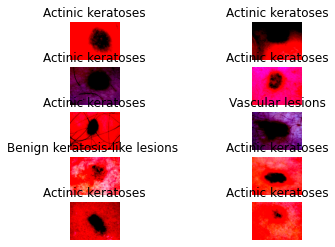

In [35]:
for i in range(10):
    plt.subplot(5, 2, i+1);
    plt.imshow(x_test[500+i]);
    plt.title(values_list[np.argmax(model_resnet50.predict(x_test[500+i].reshape(-1, 75, 100, 3)))]);
    plt.axis('off');


In [53]:
acc = 0
for i in range(1000):
  if values_list[np.argmax(y_test[500+i])] == values_list[np.argmax(model_resnet50.predict(x_test[500+i].reshape(-1, 75, 100, 3)))]:
    acc += 1
print(acc/100)

8.09


In [50]:
acc = 0
for i in range(100):
  if values_list[np.argmax(y_test[400+i])] == values_list[np.argmax(model_resnet50.predict(x_test[400+i].reshape(-1, 75, 100, 3)))]:
    acc += 1
print(acc/100)

0.83


In [51]:
acc = 0
for i in range(100):
  if values_list[np.argmax(y_test[300+i])] == values_list[np.argmax(model_resnet50.predict(x_test[300+i].reshape(-1, 75, 100, 3)))]:
    acc += 1
print(acc/100)

0.77


In [52]:
acc = 0
for i in range(100):
  if values_list[np.argmax(y_test[0+i])] == values_list[np.argmax(model_resnet50.predict(x_test[0+i].reshape(-1, 75, 100, 3)))]:
    acc += 1
print(acc/100)

0.83


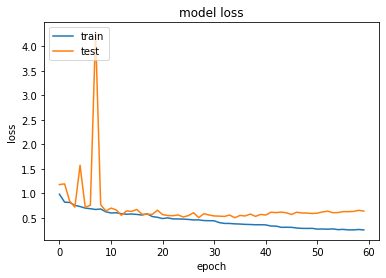

In [47]:
plt.plot(history_resnet50.history['loss'])
plt.plot(history_resnet50.history['val_loss'])
plt.title('model loss')

plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

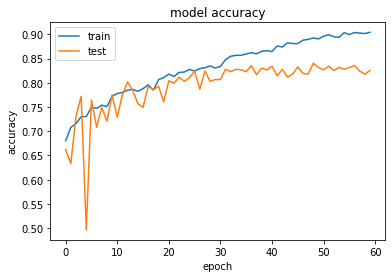

In [49]:
plt.plot(history_resnet50.history['accuracy'])
plt.plot(history_resnet50.history['val_accuracy'])
plt.title('model accuracy')

plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend(['train', 'test'], loc = 'upper left')
plt.show()